In [27]:
import os

In [28]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# configures matplotlib to inline and will display graphs below the corresponding cell
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from keras.preprocessing.image import ImageDataGenerator

#libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

#for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

#manipulation of zipped images and getting numpy arrays of pixel values of images
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image


In [29]:
X = []
Z = []
IMG_SIZE = 150
FLOWER_SUNFLOWER_DIR = '../flowers/sunflower'
FLOWER_ROSE_DIR = '../flowers/rose'
FLOWER_TULIP_DIR = '../flowers/tulip'
FLOWER_DAISY_DIR = '../flowers/daisy'
FLOWER_IRIS_DIR = '../flowers/iris'

In [30]:
def assign_label(img,flower_type):
    return flower_type

In [31]:
def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, flower_type)
        path = os.path.join(DIR, img)
        ext = img[-4:]
        if (ext != '.jpg'):
            continue
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        

In [32]:
make_train_data('Sunflower', FLOWER_SUNFLOWER_DIR)
print(len(X))



100%|██████████| 734/734 [00:01<00:00, 480.45it/s]

734


In [33]:
make_train_data('Tulip', FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:01<00:00, 552.65it/s]

1718


In [34]:
make_train_data('Rose', FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:01<00:00, 602.37it/s]

2502


In [35]:
make_train_data('Daisy', FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:01<00:00, 610.39it/s]

3271


In [36]:
make_train_data('Iris', FLOWER_IRIS_DIR)
print(len(X))

100%|██████████| 1076/1076 [00:02<00:00, 488.18it/s]

3972


In [37]:
def blur():
    for i in range(1, len(X)):
        X[i] = cv2.GaussianBlur(X[i], (5, 5), 0) 

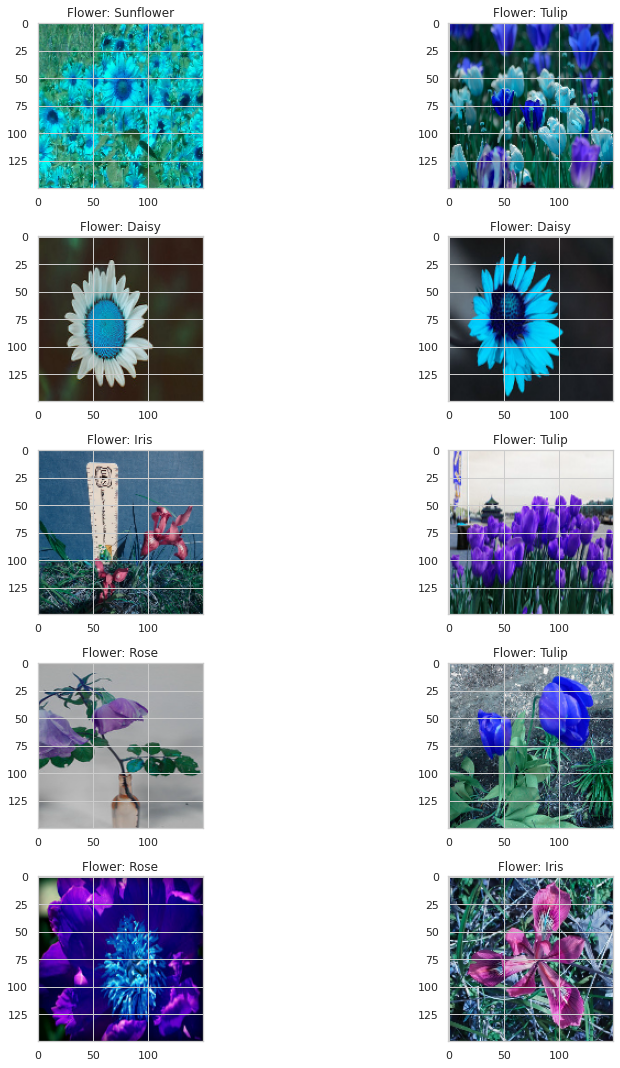

In [38]:
#visualize 10 random images with blurring preprocessing
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i, j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
plt.tight_layout()


In [39]:
# label encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [40]:
#splitting into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [41]:
#inputting the random seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [42]:
# Using CNN to start modelling

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [43]:
# Using a LR Annealer

batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [44]:
# data augmentation to pevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [45]:
# compiling the model & summary
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 96)       

In [46]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

In [47]:
# fitting training set and making predictions on the validation set
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
23/23 [==============================] - 11s 492ms/step - loss: 1.5248 - accuracy: 0.3104 - val_loss: 1.2792 - val_accuracy: 0.4673
Epoch 2/50
23/23 [==============================] - 11s 470ms/step - loss: 1.2188 - accuracy: 0.4977 - val_loss: 1.0938 - val_accuracy: 0.5811
Epoch 3/50
23/23 [==============================] - 11s 472ms/step - loss: 1.0572 - accuracy: 0.5794 - val_loss: 1.0663 - val_accuracy: 0.5619
Epoch 4/50
23/23 [==============================] - 11s 472ms/step - loss: 0.9684 - accuracy: 0.6065 - val_loss: 0.9837 - val_accuracy: 0.6133
Epoch 5/50
23/23 [==============================] - 11s 489ms/step - loss: 0.9140 - accuracy: 0.6386 - val_loss: 0.9098 - val_accuracy: 0.6506
Epoch 6/50
23/23 [==============================] - 11s 458ms/step - loss: 0.9130 - accuracy: 0.6338 - val_loss: 0.8916 - val_accuracy: 0.6385
Epoch 7/50
23/23 [==============================] - 11s 486ms/step - loss: 0.9004 - accuracy: 0.6501 - val_loss: 0.9493 - val_accuracy: 0.6304

In [48]:
# fitting training set and making prediction on the validation set
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
23/23 [==============================] - 11s 485ms/step - loss: 0.2633 - accuracy: 0.9025 - val_loss: 0.7345 - val_accuracy: 0.8087
Epoch 2/50
23/23 [==============================] - 11s 474ms/step - loss: 0.2803 - accuracy: 0.8993 - val_loss: 0.6148 - val_accuracy: 0.8177
Epoch 3/50
23/23 [==============================] - 11s 468ms/step - loss: 0.2782 - accuracy: 0.8972 - val_loss: 0.7032 - val_accuracy: 0.8187
Epoch 4/50
23/23 [==============================] - 11s 473ms/step - loss: 0.2656 - accuracy: 0.9021 - val_loss: 0.6022 - val_accuracy: 0.8338
Epoch 5/50
23/23 [==============================] - 11s 483ms/step - loss: 0.2273 - accuracy: 0.9158 - val_loss: 0.6513 - val_accuracy: 0.8107
Epoch 6/50
23/23 [==============================] - 11s 474ms/step - loss: 0.2401 - accuracy: 0.9102 - val_loss: 0.8673 - val_accuracy: 0.7855
Epoch 7/50
23/23 [==============================] - 12s 500ms/step - loss: 0.2843 - accuracy: 0.8974 - val_loss: 0.7411 - val_accuracy: 0.7724

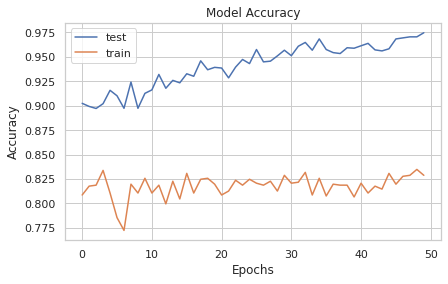

In [49]:
# graph for model accuracy between training and validation
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['test', 'train'])
plt.show()